In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import scipy.optimize as spo
import scipy.stats as sts
plt.style.use('seaborn')

#### Unimportant Warnings

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

## New HDF5 Data Import
The long waiting time has been relegated to a different notebook, and now this notebook imports the clean data directly from an HDF5 file.

In [3]:
run_label = '2020_11_09' ## Change this to look at different runs
hdf_name = '{}_clean_data.h5'.format(run_label)

In [4]:
gases = ['H2', 'H2O', 'N2', 'O2', 'CO2']
gas_tables = [] # appendable list of gas data tables from HDF5

for gas in gases:
    gas_tables.append(pd.read_hdf(hdf_name, key=gas))

### Curve Fitting
$$p(t,T) = A\cdot \exp\left(-\frac{b}{T}\right)\cdot\exp\left(-c\cdot t\cdot \exp\left(-\frac{b}{T}\right)\right)$$

In [5]:
def pressure_fit(tT, A, b, c):
    # (k,M) array if there are k predictors
    factor = np.exp(-1.0*b/tT[1])
    return A * factor * np.exp(-1.0*c*tT[0]*factor)

In [6]:
def all_jumps_fit(tT_array, pressure_array, params, b, c, bounds):
    """Fit all jumps of a gas at once so that it is constrained to one pair of b, c.
    
    Arguments:
    tT_arrays: list of each tT array from each jump
    jump_pressures: list of pressure arrays for each jump
    b: Fitting parameter (Ea/k_B)
    c: Time constant (related to D_0)
    bounds: list of start end end times of each jump"""
    #print('Check 1')
    
    jump_tT_arrays = []
    jump_pressures = []
    
    for bounds in jump_bounds:
        t = tT_array[0][np.where(np.logical_and(CO2_tT_array[0]>=bounds[0], CO2_tT_array[0]<bounds[1]))]
        T = tT_array[1][np.where(np.logical_and(CO2_tT_array[0]>=bounds[0], CO2_tT_array[0]<bounds[1]))]
        jump_tT = np.array([t,T])
        jump_tT_arrays.append(jump_tT)
        
        jump_pressure = pressure_array[np.where(np.logical_and(tT_array[0]>=bounds[0], tT_array[0]<bounds[1]))]
        jump_pressures.append(jump_pressure)
    
    jump_fits_list = []
    
    for idx, jump_tT in enumerate(jump_tT_arrays):
        #print('Check 2: loop {}'.format(idx+1))
        # Fit each jump individually. E.g. spo.curve_fit(lambda tT, A: pressure_fit(tT, A, b, c), ...)
        popt, pcov = spo.curve_fit(lambda tT, A: pressure_fit(tT, A, b, c), jump_tT, jump_pressures[idx], p0=params, maxfev=100000)
        # Calculate predicted pressure values based on curve fit parameters for each jump separately.
        jump_fits = pressure_fit(jump_tT, popt[0], b, c)
        jump_fits_list.append(jump_fits)

    # Concatenate all the predicted pressure values into one big array
    # Return that array to compare against the real pressure values
    return np.concatenate(jump_fits_list)

In [7]:
#O2_jump1 = O2_final_data[O2_final_data['Datetime'].between(51000, 65000)]

In [8]:
jump_bounds = [[51000, 64600],[64600, 90000],[90000, 110200],[110200, 150000]]
init_params = [7, 1925.28, 0.00532]

In [9]:
CO2_jumpsonly_table = gas_tables[4][gas_tables[4]['exp_time'].between(jump_bounds[0][0], jump_bounds[-1][1])]
CO2_tT_array = CO2_jumpsonly_table.sort_values(by='exp_time')[['exp_time', 'ch1_lerp']].T.to_numpy()
CO2_pressure_array = CO2_jumpsonly_table.sort_values(by='exp_time')['pressure'].T.to_numpy()

In [10]:
%%capture
CO2_tT_arrays = []
CO2_pressure_arrays = []
CO2_jump_starts = []
for idx, bounds in enumerate(jump_bounds):
    jump_table = gas_tables[4][gas_tables[4]['exp_time'].between(bounds[0], bounds[1])]
    jump_time_start = jump_table.sort_values(by='exp_time')['exp_time'].unique()[0]
    jump_table['jump_time'] = jump_table['exp_time'] - jump_time_start
    CO2_tT_arrays.append(jump_table[['jump_time', 'ch1_lerp']].T.to_numpy())
    CO2_pressure_arrays.append(jump_table['pressure'].to_numpy())
    CO2_jump_starts.append(jump_time_start)

Quick graph to prove that the arrays do what they should be doing:

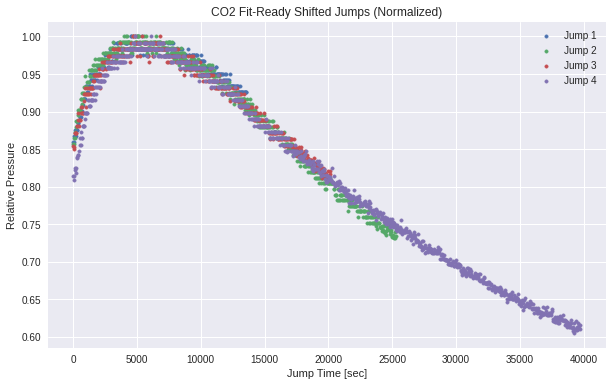

In [11]:
fig, ax = plt.subplots(figsize=(10,6))

for idx, tT in enumerate(CO2_tT_arrays):
    ax.scatter(tT[0,:], CO2_pressure_arrays[idx]/np.max(CO2_pressure_arrays[idx]), marker='.', label='Jump {}'.format(idx+1))

ax.set_title('CO2 Fit-Ready Shifted Jumps (Normalized)')
#ax.set_ylabel('Pressure [torr]')
ax.set_ylabel('Relative Pressure')
ax.set_xlabel('Jump Time [sec]')
ax.legend()

plt.show()

In [12]:
print("{} {}".format(CO2_tT_arrays[3].shape, CO2_pressure_arrays[3].shape))

(2, 960) (960,)


In [13]:
CO2_fit_pressures = all_jumps_fit(CO2_tT_array, CO2_pressure_array, [init_params[0]], init_params[1], init_params[2], jump_bounds)
CO2_fit_times = np.concatenate([array[0,:]+CO2_jump_starts[idx] for idx, array in enumerate(CO2_tT_arrays)])

In [14]:
popt, pcov = spo.curve_fit(lambda tT, A: pressure_fit(tT, A, init_params[1], init_params[2]), CO2_tT_arrays[1], CO2_pressure_arrays[1], p0=[init_params[0]], maxfev=100000)
jump_fits = pressure_fit(CO2_tT_arrays[1], popt[0], init_params[1], init_params[2])

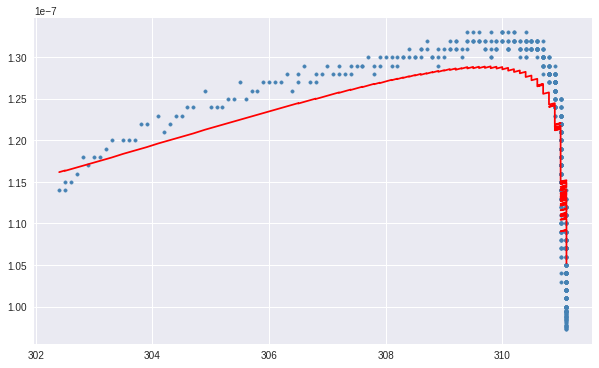

In [15]:
fig, ax = plt.subplots(figsize=(10,6))

ax.scatter(CO2_tT_arrays[1][1], CO2_pressure_arrays[1], marker='.', color='steelblue')
ax.plot(CO2_tT_arrays[1][1], jump_fits, color='red')

#ax2 = ax.twinx()
#ax2.plot(CO2_tT_arrays[1][0]/3600, CO2_tT_arrays[1][1], color='darkorange', label='Top Channel')
#ax2.legend(loc='lower center')

plt.show()

In [16]:
popt, pcov = spo.curve_fit(lambda tT, A: pressure_fit(tT, A, init_params[1], init_params[2]), CO2_tT_arrays[3], CO2_pressure_arrays[3], p0=[init_params[0]], maxfev=100000)
jump_fits = pressure_fit(CO2_tT_arrays[3], popt[0], init_params[1], init_params[2])

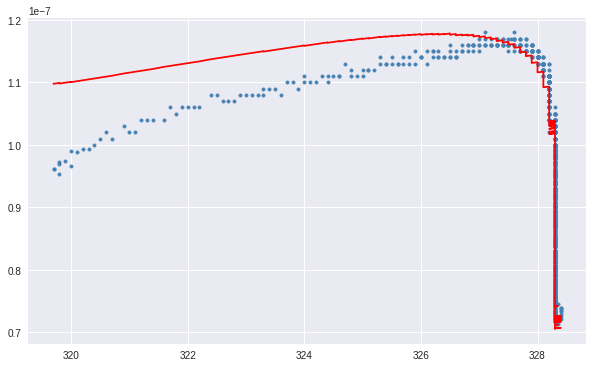

In [17]:
fig, ax = plt.subplots(figsize=(10,6))

ax.scatter(CO2_tT_arrays[3][1], CO2_pressure_arrays[3], marker='.', color='steelblue')
ax.plot(CO2_tT_arrays[3][1], jump_fits, color='red')

#ax2 = ax.twinx()
#ax2.plot(CO2_tT_arrays[3][0]/3600, CO2_tT_arrays[3][1], color='darkorange', label='Top Channel')
#ax2.legend(loc='lower center')

plt.show()

So obviously the initial guess was way off, but this proves that the fitting function is doing what it's supposed to do: optimizing only over `A` and leaving the other two parameters alone.

In [18]:
popt, pcov = spo.curve_fit(lambda tT, b, c: all_jumps_fit(tT, CO2_pressure_array, [init_params[0]], b, c, jump_bounds), CO2_tT_array, CO2_pressure_array, p0=init_params[1:], maxfev=100000)

In [19]:
CO2_fit_pressures = all_jumps_fit(CO2_tT_array, CO2_pressure_array, [init_params[0]], init_params[1], init_params[2], jump_bounds)

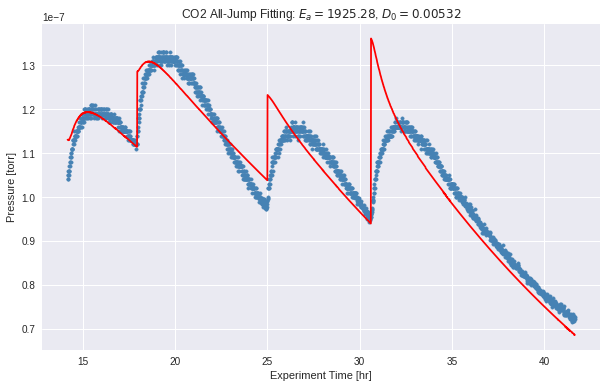

In [20]:
fig, ax = plt.subplots(figsize=(10,6))

ax.scatter(CO2_tT_array[0]/3600, CO2_pressure_array, marker='.', color='steelblue', label='Measured Pressure')
ax.plot(CO2_tT_array[0]/3600, CO2_fit_pressures, color='red', label='Projected Pressure from Fit')

ax.set_title('CO2 All-Jump Fitting: $E_a={}$, $D_0={}$'.format(round(init_params[1],2), round(init_params[2],6)))
ax.set_xlabel('Experiment Time [hr]')
ax.set_ylabel('Pressure [torr]')

plt.show()

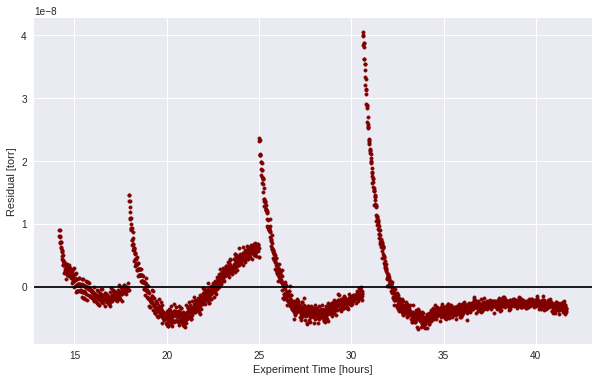

In [21]:
fig, ax = plt.subplots(figsize=(10,6))

ax.scatter(CO2_tT_array[0]/3600, CO2_fit_pressures-CO2_pressure_array, marker='.', color='maroon')
ax.axhline(color='k')

ax.set_ylabel('Residual [torr]')
ax.set_xlabel('Experiment Time [hours]')

plt.show()

In [22]:
CO2_fit_pressures = all_jumps_fit(CO2_tT_array, CO2_pressure_array, [init_params[0]], popt[0], popt[1], jump_bounds)

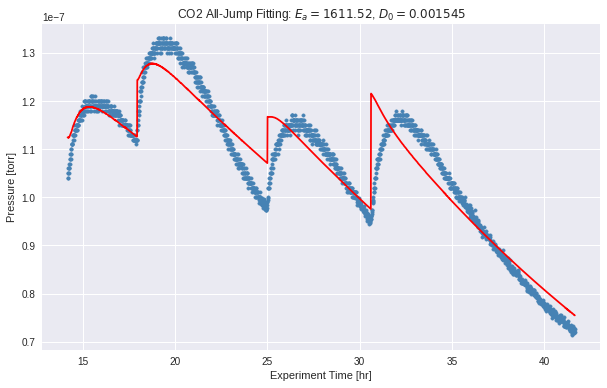

In [23]:
fig, ax = plt.subplots(figsize=(10,6))

ax.scatter(CO2_tT_array[0]/3600, CO2_pressure_array, marker='.', color='steelblue', label='Measured Pressure')
ax.plot(CO2_tT_array[0]/3600, CO2_fit_pressures, color='red', label='Projected Pressure from Fit')

ax.set_title('CO2 All-Jump Fitting: $E_a={}$, $D_0={}$'.format(round(popt[0],2), round(popt[1],6)))
ax.set_xlabel('Experiment Time [hr]')
ax.set_ylabel('Pressure [torr]')

plt.show()

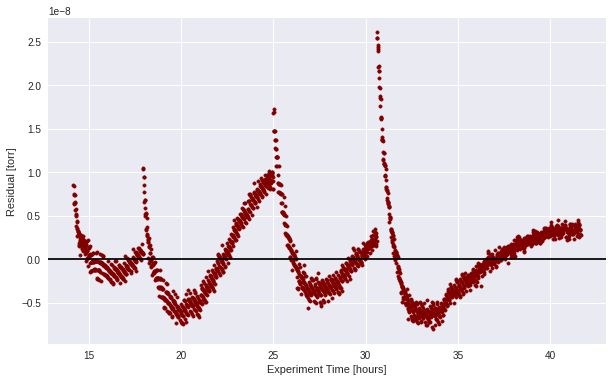

In [24]:
fig, ax = plt.subplots(figsize=(10,6))

ax.scatter(CO2_tT_array[0]/3600, CO2_fit_pressures-CO2_pressure_array, marker='.', color='maroon')
ax.axhline(color='k')

ax.set_ylabel('Residual [torr]')
ax.set_xlabel('Experiment Time [hours]')

plt.show()

In [25]:
def jump_analysis(data_table, bounds, params):
    """Output the time, pressure data, and fit values for one CO2 jump defined
    by the bounds.
    
    Arguments
    bounds: a two-element list of [lower bound, upper bound]
    params: a three-element list of [A, b, c] from the pressure_fit function"""

    jump_table = data_table[data_table['exp_time'].between(bounds[0], bounds[1])]
    jump_time_start = jump_table['exp_time'].unique()[0]
    jump_table['jump_time'] = jump_table['exp_time'] - jump_time_start
    time_temp_vals = jump_table[['jump_time', 'temp_est']].T.to_numpy()
    fit_jump = jump_table['pressure'].to_numpy()
    popt, pcov = spo.curve_fit(pressure_fit, time_temp_vals, fit_jump, p0=params, maxfev=100000)
    jump_fits = pressure_fit(time_temp_vals, popt[0], popt[1], popt[2])
    
    return jump_table['exp_time'], jump_table['CO2_Pressure'], jump_fits, popt, pcov, time_temp_vals

In [26]:
def alt_jump_analysis(data_table, bounds, params):
    """Output the time, pressure data, and fit values for one CO2 jump defined
    by the bounds.
    
    Arguments
    bounds: a two-element list of [lower bound, upper bound]
    params: a three-element list of [A, b, c] from the pressure_fit function"""

    jump_table = data_table[data_table['exp_time'].between(bounds[0], bounds[1])]
    jump_time_start = jump_table['exp_time'].unique()[0]
    jump_table['jump_time'] = jump_table['exp_time'] - jump_time_start
    time_temp_vals = jump_table[['jump_time', 'ch1_lerp']].T.to_numpy()
    fit_jump = jump_table['pressure'].to_numpy()
    popt, pcov = spo.curve_fit(pressure_fit, time_temp_vals, fit_jump, p0=params, maxfev=100000)
    jump_fits = pressure_fit(time_temp_vals, popt[0], popt[1], popt[2])
    
    return jump_table['exp_time'], jump_table['pressure'], jump_fits, popt, pcov, time_temp_vals

In [27]:
#gas_tables[4][gas_tables[4]['exp_time'].between(jump_bounds[3][0], jump_bounds[3][1])]

In [28]:
jump_bounds[1][0]

64600

In [29]:
def fitting_scan(data_table, bounds, Ea_range, D_range, num_values):
    
    Ea_vals = np.linspace(Ea_range[0], Ea_range[1], num=num_values)
    D_vals = np.linspace(D_range[0], D_range[1], num=num_values)
    #Ea_D_array = np.transpose([np.tile(Ea_vals, len(D_vals)), np.repeat(D_vals, len(Ea_vals))])
    
    gas_ssq = np.zeros((Ea_vals.shape[0], D_vals.shape[0]))
    
    for idx, jump_bound in enumerate(bounds):
        jump_table = data_table[data_table['exp_time'].between(jump_bound[0], jump_bound[1])]
        jump_time_start = jump_table['exp_time'].unique()[0]
        jump_table['jump_time'] = jump_table['exp_time'] - jump_time_start
        time_temp_vals = jump_table[['jump_time', 'ch1_lerp']].T.to_numpy()
        fit_jump = jump_table['pressure'].to_numpy()
        for x, Ea in enumerate(Ea_vals):
            for y, D in enumerate(D_vals):
                popt, pcov = spo.curve_fit(lambda tT, A: pressure_fit(tT, A, Ea, D),
                                       time_temp_vals, fit_jump, p0=[7], maxfev=100000)
                jump_fits = pressure_fit(time_temp_vals, popt[0], Ea, D)
                resids = jump_fits - fit_jump
                resids = resids
                ssq = np.dot(resids, resids)/(7.5e-10**2)
                gas_ssq[x, y] += ssq
    
    return Ea_vals, D_vals, gas_ssq

In [30]:
%%capture
#Ea_range = [1.925e+03, 1.928e+03]
#D_range = [5.32e-03, 5.36e-03]
Ea_range = [0, 3000]
D_range = [0, 1e-2]
CO2_Ea, CO2_D, CO2_ssq = fitting_scan(gas_tables[4], jump_bounds, Ea_range, D_range, num_values=75)

In [31]:
%%capture
#Ea_range = [5000, 7000]
#D_range = [0, 1]
#O2_Ea, O2_D, O2_ssq = fitting_scan(gas_tables[3], jump_bounds, Ea_range, D_range, num_values=75)

In [32]:
#pd.DataFrame(data=CO2_ssq)

In [33]:
CO2_min_index = np.unravel_index(np.argmin(CO2_ssq), CO2_ssq.shape)
CO2_best_Ea = CO2_Ea[CO2_min_index[0]]
CO2_best_D = CO2_D[CO2_min_index[1]]

In [34]:
print(CO2_best_Ea, CO2_best_D)

1905.4054054054054 0.005


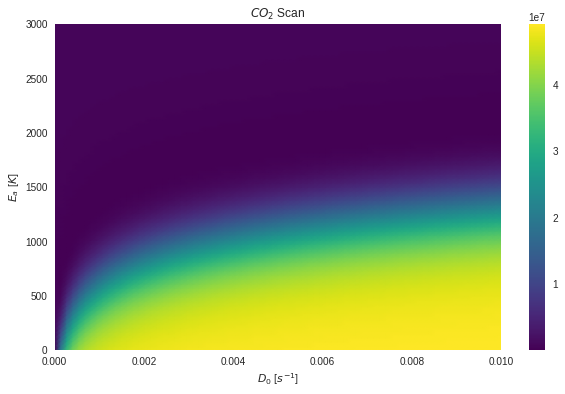

In [35]:
fig, ax = plt.subplots(figsize=(10,6))
CO2_heat = ax.pcolormesh(CO2_D, CO2_Ea, CO2_ssq, cmap='viridis', shading='gouraud')
ax.set_title('$CO_2$ Scan')
ax.set_ylabel('$E_a$ [$K$]')
ax.set_xlabel('$D_0$ [$s^{-1}$]')
plt.colorbar(CO2_heat)

#O2_heat = ax[1].pcolormesh(np.log(O2_ssq), cmap='viridis', shading='gouraud')
#ax[1].set_title('$O_2$ Scan')
#ax[1].set_ylabel('$E_a$')
#ax[1].set_xlabel('$D_0$')

fig.savefig('images/co2_scan_2020_11_09.png', dpi=144)
plt.show()

In [36]:
%%capture
alt_jump_outs = []
# Warnings incoming. Not a problem
for idx, gas in enumerate(gases):
    gas_jumps = []
    for listed_jump in jump_bounds:
        gas_jump_out = alt_jump_analysis(gas_tables[idx], listed_jump, init_params)
        gas_jumps.append(gas_jump_out)
    alt_jump_outs.append(gas_jumps)

The code from the above cell creates a 3-layer nested list.
- First index: which gas
- Second index: which jump
- Third index: times, pressures, fit pressures, fitted parameter values, covariance matrix, time-and-temperature table

In [37]:
# Sample output: the popt values from CO2 jump 1
alt_jump_outs[4][0][3]

array([6.86386075e-05, 1.89812143e+03, 5.34528899e-03])

### Plotting

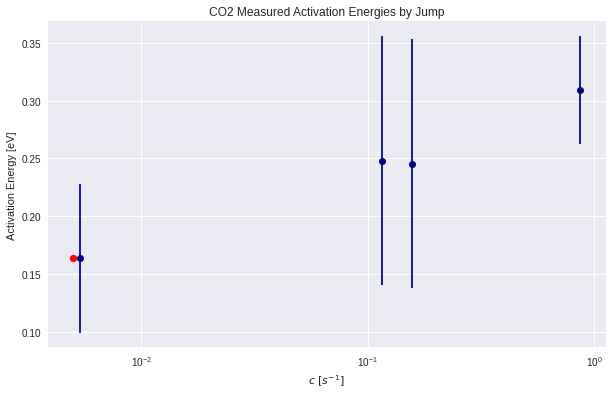

In [38]:
CO2_Ea_vals = np.array([alt_jump_outs[4][0][3][1], alt_jump_outs[4][1][3][1], alt_jump_outs[4][2][3][1], alt_jump_outs[4][3][3][1]])
CO2_Ea_errs = np.array([alt_jump_outs[4][0][4][1][1], alt_jump_outs[4][1][4][1][1], alt_jump_outs[4][2][4][1][1], alt_jump_outs[4][3][4][1][1]])
CO2_D_vals = np.array([alt_jump_outs[4][0][3][2], alt_jump_outs[4][1][3][2], alt_jump_outs[4][2][3][2], alt_jump_outs[4][3][3][2]])
CO2_D_errs = np.array([alt_jump_outs[4][0][4][2][2], alt_jump_outs[4][1][4][2][2], alt_jump_outs[4][2][4][2][2], alt_jump_outs[4][3][4][2][2]])

k_B = 8.617e-5 # Boltzmann constant in eV/K

fig, ax = plt.subplots(figsize=(10,6))
ax.errorbar(CO2_D_vals, CO2_Ea_vals*k_B, yerr=CO2_Ea_errs*k_B, xerr=CO2_D_errs, fmt='o', color='navy')
ax.scatter(CO2_best_D, CO2_best_Ea*k_B, color='red')

ax.set_title('CO2 Measured Activation Energies by Jump')
ax.set_xlabel('$c$ $\\left[s^{-1}\\right]$')
ax.set_ylabel('Activation Energy [eV]')
ax.set_xscale('log')

fig.savefig('images/co2_Ea_vals_2020_11_09.png', dpi=144)
plt.show()

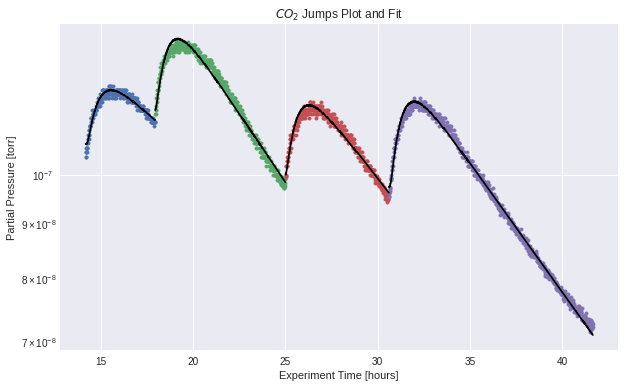

In [39]:
fig, ax = plt.subplots(figsize=(10,6))
for i in range(4):
    ax.scatter(alt_jump_outs[4][i][0]/3600, alt_jump_outs[4][i][1], marker='.')
    ax.plot(alt_jump_outs[4][i][0]/3600, alt_jump_outs[4][i][2], color='black')

#for idx, guess in enumerate(CO2_Ea_guesses):
#    ax.plot(CO2_jump4_alt[0]/3600, CO2_jump4_guessfits[idx], label='Ea = {}'.format(guess))
ax.set_ylabel('Partial Pressure [torr]')
ax.set_xlabel('Experiment Time [hours]')
ax.set_title('$CO_2$ Jumps Plot and Fit')
#ax.legend()
ax.set_yscale('log')
fig.savefig('images/co2_all_fits_2020_11_09.png', dpi=144)

plt.show()

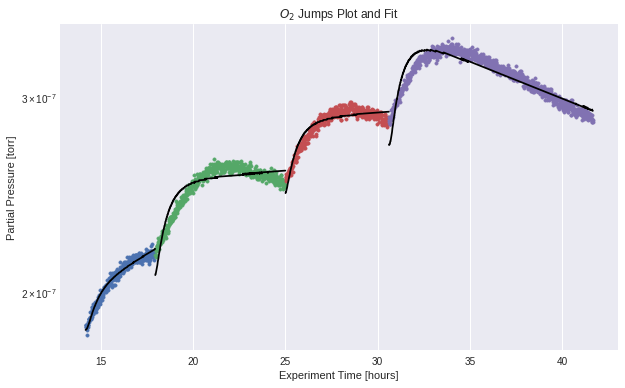

In [40]:
fig, ax = plt.subplots(figsize=(10,6))
for i in range(len(jump_bounds)):
    ax.scatter(alt_jump_outs[3][i][0]/3600, alt_jump_outs[3][i][1], marker='.')
    ax.plot(alt_jump_outs[3][i][0]/3600, alt_jump_outs[3][i][2], color='black')

#for idx, guess in enumerate(CO2_Ea_guesses):
#    ax.plot(CO2_jump4_alt[0]/3600, CO2_jump4_guessfits[idx], label='Ea = {}'.format(guess))
ax.set_ylabel('Partial Pressure [torr]')
ax.set_xlabel('Experiment Time [hours]')
ax.set_title('$O_2$ Jumps Plot and Fit')
#ax.legend()
ax.set_yscale('log')
fig.savefig('images/o2_all_fits_2020_11_09.png', dpi=144)

plt.show()

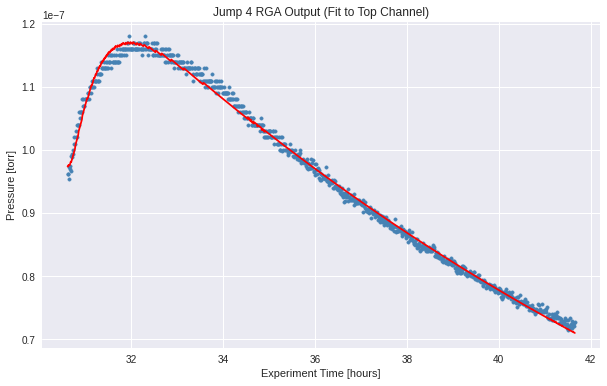

In [41]:
fig, ax1 = plt.subplots(figsize=(10,6))
ax1.scatter(alt_jump_outs[4][3][0]/3600, alt_jump_outs[4][3][1], marker='.', color='steelblue', label='RGA Output')
ax1.plot(alt_jump_outs[4][3][0]/3600, alt_jump_outs[4][3][2], color='red', label='RGA Fit')

ax1.set_title('Jump 4 RGA Output (Fit to Top Channel)')
ax1.set_xlabel('Experiment Time [hours]')
ax1.set_ylabel('Pressure [torr]')
#ax1.set_yscale('log')

plt.savefig('images/co2_4_alt_2020_11_09.png', dpi=144)

plt.show()

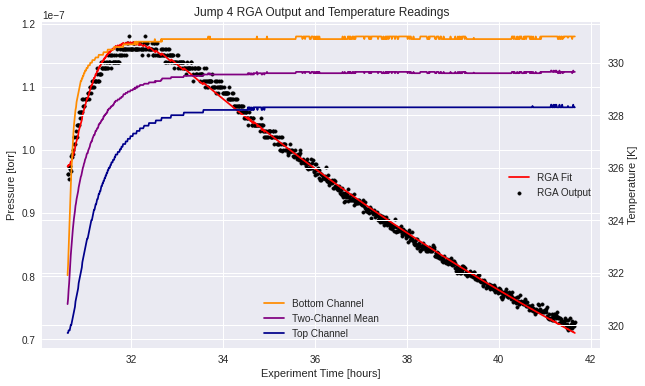

In [42]:
jump4_temps = gas_tables[4][gas_tables[4]['exp_time'].between(jump_bounds[3][0], jump_bounds[3][1])][['ch1_lerp', 'ch2_lerp', 'mean_temp']]

fig, ax1 = plt.subplots(figsize=(10,6))
ax1.scatter(alt_jump_outs[4][3][0]/3600, alt_jump_outs[4][3][1], marker='.', color='black', label='RGA Output')
ax1.plot(alt_jump_outs[4][3][0]/3600, alt_jump_outs[4][3][2], color='red', label='RGA Fit')

ax2 = ax1.twinx()

ax2.plot(alt_jump_outs[4][3][0]/3600, jump4_temps['ch2_lerp'], color='darkorange', label='Bottom Channel')
ax2.plot(alt_jump_outs[4][3][0]/3600, jump4_temps['mean_temp'], color='purple', label='Two-Channel Mean')
ax2.plot(alt_jump_outs[4][3][0]/3600, jump4_temps['ch1_lerp'], color='darkblue', label='Top Channel')

ax1.set_title('Jump 4 RGA Output and Temperature Readings')
ax1.set_xlabel('Experiment Time [hours]')
ax1.set_ylabel('Pressure [torr]')
ax1.legend(loc='right')

ax2.set_ylabel('Temperature [K]')
ax2.legend(loc='lower center')

plt.savefig('images/co2_4_fit_2020_11_09.png', dpi=144)
plt.show()

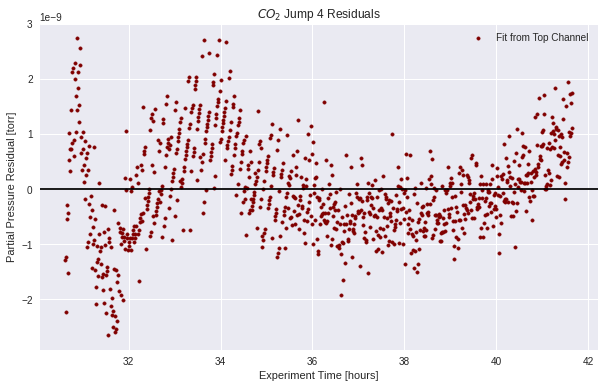

In [43]:
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(alt_jump_outs[4][3][0]/3600, alt_jump_outs[4][3][1] - alt_jump_outs[4][3][2], marker='.', color='maroon', label='Fit from Top Channel')
ax.set_ylabel('Partial Pressure Residual [torr]')
ax.set_xlabel('Experiment Time [hours]')
ax.axhline(color='k')
ax.set_title('$CO_2$ Jump 4 Residuals')
ax.legend()

fig.savefig('images/co2_4_resid_2020_11_09.png', dpi=144)

plt.show()

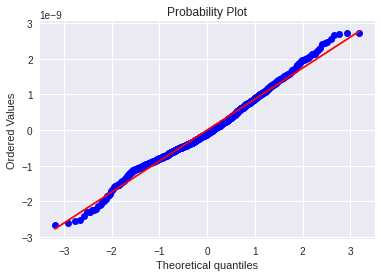

In [44]:
jump4_prob = sts.probplot(alt_jump_outs[4][3][1] - alt_jump_outs[4][3][2], plot=plt)

In [45]:
#CO2_data['Pressure'].iloc[np.array(CO2_times.between(50000,110000))]

### Finding the Bounds of Each Jump

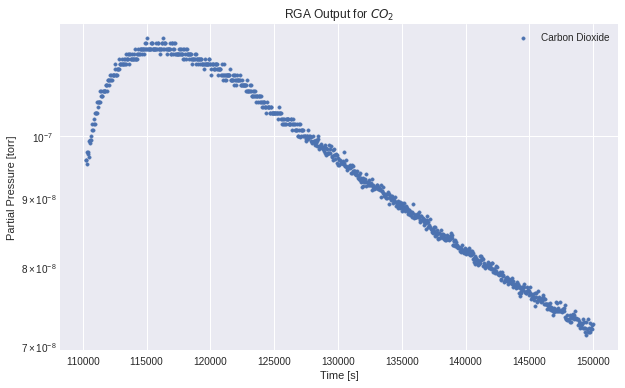

In [46]:
bnds = [110200, 150000]

fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(gas_tables[4]['exp_time'].iloc[np.array(gas_tables[4]['exp_time'].between(bnds[0],bnds[1]))],
           gas_tables[4]['pressure'].iloc[np.array(gas_tables[4]['exp_time'].between(bnds[0],bnds[1]))], marker='.', label='Carbon Dioxide')
ax.set_title('RGA Output for $CO_2$')
ax.set_xlabel('Time [s]')
ax.set_ylabel('Partial Pressure [torr]')
ax.legend()
ax.set_yscale('log')

plt.show()

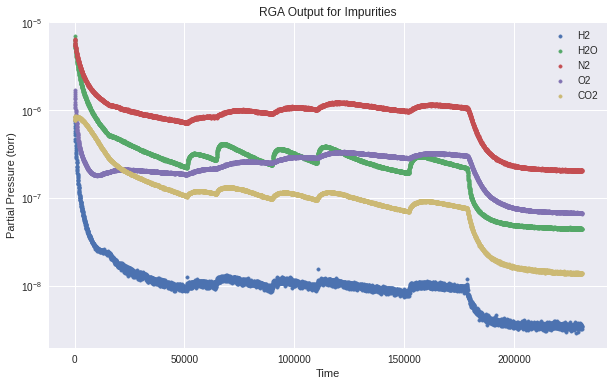

In [47]:
fig, ax = plt.subplots(figsize=(10,6))

for idx, gas in enumerate(gases):
    ax.scatter(gas_tables[idx]['exp_time'], gas_tables[idx]['pressure'], marker='.', label=gas)

ax.set_title('RGA Output for Impurities')
ax.set_xlabel('Time')
ax.set_ylabel('Partial Pressure (torr)')
ax.legend()
ax.set_yscale('log')

#ax[1].plot(temp_times, pd.to_numeric(Temp['CH1']), label='Channel 1')
#ax[1].plot(temp_times, pd.to_numeric(Temp['CH2']), label='Channel 2', color='darkorange')
#ax[1].set_title('Temperature over Time from Top and Bottom Channels')
#ax[1].set_xlabel('Time [sec]')
#ax[1].set_ylabel('Temperature (C)')
#ax[1].legend()

fig.savefig('plot_out_{}.png'.format(run_label), dpi=300)
plt.show()

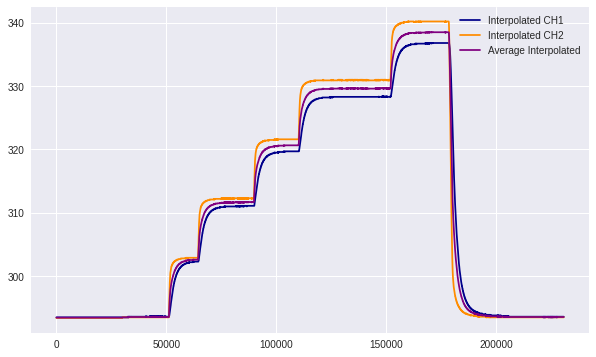

In [48]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(gas_tables[4]['exp_time'], gas_tables[4]['ch1_lerp'], label='Interpolated CH1', color='darkblue')
ax.plot(gas_tables[4]['exp_time'], gas_tables[4]['ch2_lerp'], label='Interpolated CH2', color='darkorange')
ax.plot(gas_tables[4]['exp_time'], gas_tables[4]['mean_temp'], label='Average Interpolated', color='purple')
ax.legend()

plt.show()

In [49]:
#IO.RemoveZipDir()